## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

1. **Critical Care Protocols:** "What is the protocol for managing sepsis in a critical care unit?"

2. **General Surgery:** "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

3. **Dermatology:** "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

4. **Neurology:** "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [ ]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              datasets==4.0.0 \
              evaluate==0.4.5 \
              langchain_openai==0.3.30

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.4 MB/s eta 0:00:

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [ ]:
import os                                                                 # Used for interacting with the operating system
import json
import re
import torch                                                              # PyTorch library, often used for deep learning models

import fitz                                                               # PyMuPDF, used for reading PDF files

import pandas as pd                                                       # Pandas library for data manipulation and analysis

from openai import OpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter        # Used for splitting text into chunks
from langchain_community.vectorstores import Chroma                       # Vector database for storing embeddings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI                 # For creating embeddings using OpenAI models and using OpenAI chat models
from langchain.chains import RetrievalQA                                  # For creating a retrieval-based question-answering chain
from langchain_core.messages import SystemMessage, HumanMessage           # Import message classes



In [ ]:
# Reads API keys and tokens from a config.json file and sets them as environment variables.

config_file_path = 'config.json'
try:
    # Open and load the configuration file
    with open(config_file_path, 'r') as f:
        config = json.load(f)

    # Set environment variables from the config dictionary
    if 'HF_TOKEN' in config:
        os.environ["HF_TOKEN"] = config['HF_TOKEN']
        print("HF_TOKEN environment variable set.")
    if 'OPENAI_API_KEY' in config:
        os.environ["OPENAI_API_KEY"] = config['OPENAI_API_KEY']
        print("OPENAI_API_KEY environment variable set.")
    if 'OPENAI_API_BASE' in config:
        os.environ["OPENAI_API_BASE"] = config['OPENAI_API_BASE']
        print("OPENAI_API_BASE environment variable set.")

except FileNotFoundError:
    # Handle case where the config file is not found
    print(f"Error: {config_file_path} not found. Please make sure the config file exists.")
except json.JSONDecodeError:
    # Handle case where the JSON format is incorrect
    print(f"Error: Could not decode JSON from {config_file_path}. Please check the file format.")
except Exception as e:
    # Handle any other unexpected errors
    print(f"An unexpected error occurred: {e}")

HF_TOKEN environment variable set.
OPENAI_API_KEY environment variable set.
OPENAI_API_BASE environment variable set.


## Question Answering using LLM

> **Note 1:** When choosing between an open-source Hugging Face (HF) model and OpenAI’s proprietary model, base your decision on your specific needs. If you opt for a Hugging Face model, make sure to connect to a GPU to execute the code efficiently.

> **Note 2**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:
1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.
2. Switch to a different Google account and resume working on the project from there.
3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

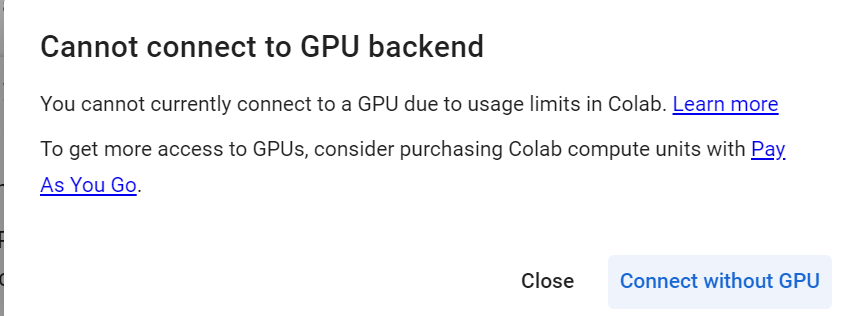

#### Downloading and Loading the model

In [ ]:
# Define the name of the OpenAI model to use
model_name = "gpt-4o-mini"

# Initialize the ChatOpenAI model and access the API key from the environment variables
openai_api_key = os.environ.get("OPENAI_API_KEY")

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")

# Check if the API key was found in the environment variables
if not openai_api_key:
    print("Error: OpenAI API key not found in environment variables.")
else:
    # If the API key is found, initialize the ChatOpenAI model
    llm = ChatOpenAI(model=model_name, api_key=openai_api_key)
    print(f"ChatOpenAI model '{model_name}' initialized successfully.")

ChatOpenAI model 'gpt-4o-mini' initialized successfully.


**Note:** Created clean_markdown function to explicitly remove markdown formatting, since I encountered an error when trying to set the response format as "text" while generating responses. (Error: `An error occurred: Error code: 404 - {'reason': 'Not Found'}`)


In [ ]:
#Function to clear markdown formatting in the responses

def clean_markdown(text):
    """
    Removes common markdown formatting and replaces newlines with spaces.

    Args:
        text: The input string with potential markdown.

    Returns:
        The cleaned string with markdown removed and newlines replaced by spaces.
    """
    # Initialize cleaned_text with the input text
    cleaned_text = text

    # Remove common markdown characters using regex
    cleaned_text = re.sub(r'###*\s*', '', cleaned_text) # Remove headers (###)
    cleaned_text = re.sub(r'\*\*', '', cleaned_text) # Remove bold (**)
    cleaned_text = re.sub(r'\*', '', cleaned_text) # Remove italics (*)
    cleaned_text = re.sub(r'^- ', '', cleaned_text, flags=re.MULTILINE) # Remove list items (-)
    cleaned_text = re.sub(r'^\d+\.\s*', '', cleaned_text, flags=re.MULTILINE) # Remove numbered list items (1.)
    cleaned_text = re.sub(r'^-\s*', '', cleaned_text, flags=re.MULTILINE) # Remove list items with no space (e.g., -Item)
    #cleaned_text = re.sub(r':\s*-', '-', cleaned_text) # Replace ": -" with "-"

    # Replace newline characters with spaces
    cleaned_text = cleaned_text.replace('\n', ' ')
    cleaned_text = cleaned_text.replace('\r', ' ')
    cleaned_text = cleaned_text.replace('\t', ' ')
    cleaned_text = cleaned_text.replace('  ', ' ')

    return cleaned_text

print("Function 'clean_markdown' defined.")

Function 'clean_markdown' defined.


In [ ]:
# Function to generate responses using gpt-4o-mini model

def generate_response_using_llm(user_input, temperature=0.1, max_tokens=512, top_p=1.0):
    """
    Generates a response from the gpt-4o-mini model and removes markdown bold and newlines.

    Args:
        user_input: The user's input prompt.
        temperature: Controls the randomness of the output. Higher values mean more random.
        max_p: The nucleus sampling probability.
        max_tokens: The maximum number of tokens to generate in the response.

    Returns:
        The cleaned generated text response from the model.
    """
    try:
        openai_api_key = os.environ.get("OPENAI_API_KEY")
        if not openai_api_key:
            return "Error: OpenAI API key not found in environment variables."

        llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key)

        response = llm.invoke(
            user_input,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p
        )
        response_content = response.content

        # clean_markdown function to remove markdown formatting
        cleaned_response = clean_markdown(response_content)

        return cleaned_response
    except Exception as e:
        return f"An error occurred: {e}"

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
question1_llm = "What is the protocol for managing sepsis in a critical care unit?"

# Generate response using the generate_response_using_llm function
response1_llm = generate_response_using_llm(question1_llm)

# Print the response
print(response1_llm)

Managing sepsis in a critical care unit involves a systematic approach to identify, stabilize, and treat the condition effectively. The following protocol outlines key steps in the management of sepsis: Early Recognition  - Identify Symptoms: Look for signs of sepsis, including fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension.  - Use Screening Tools: Utilize tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to assess the severity of sepsis. Initial Assessment  - Obtain Vital Signs: Monitor blood pressure, heart rate, respiratory rate, and temperature.  - Assess Organ Function: Evaluate renal function, liver function, coagulation status, and mental status. Immediate Interventions  - Fluid Resuscitation: Administer intravenous (IV) fluids (e.g., crystalloids) promptly, typically 30 mL/kg within the first 3 hours.  - Oxygen Therapy: Provide supplemental oxygen to maintain adequate oxygen saturation (SpO2 > 94%).  - 

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
question2_llm = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

# Generate response using the generate_response_using_llm function
response2_llm = generate_response_using_llm(question2_llm)

# Print the response
print(response2_llm)

Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then moves to the lower right abdomen. Loss of Appetite: A sudden decrease in appetite is common. Nausea and Vomiting: Often follows the onset of abdominal pain. Fever: A low-grade fever may develop. Constipation or Diarrhea: Changes in bowel habits can occur. Bloating: The abdomen may feel swollen or bloated. Inability to pass gas: This can accompany other gastrointestinal symptoms. Appendicitis cannot be effectively treated with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, known as an appendectomy. There are two main types of appendectomy: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: A minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and special instruments. In some cases, if the appendicitis is diagnos

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
question3_llm = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

# Generate response using the generate_response_using_llm function
response3_llm = generate_response_using_llm(question3_llm)

# Print the response
print(response3_llm)

Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and solutions, as well as potential causes: Possible Causes: Autoimmune Disorders: The immune system mistakenly attacks hair follicles, leading to hair loss. Genetics: A family history of alopecia or other autoimmune conditions can increase the risk. Stress: Physical or emotional stress can trigger hair loss in some individuals. Hormonal Changes: Changes in hormones, such as those occurring during pregnancy or menopause, can contribute. Nutritional Deficiencies: Lack of essential nutrients, such as iron, zinc, or vitamins, can affect hair health. Infections: Fungal infections like tinea capitis can cause patchy hair loss. Allergic Reactions: Allergies to hair products or other substances can lead to hair loss. Effective Treatments: Topical Corticosteroids: These anti-inflammatory medications can help reduce infla

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
question4_llm = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"

# Generate response using the generate_response_using_llm function
response4_llm = generate_response_using_llm(question4_llm)

# Print the response
print(response4_llm)

Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment: Emergency Care:   - Immediate medical attention is crucial. This may involve stabilizing the patient, monitoring vital signs, and performing imaging studies (like CT or MRI scans) to assess the extent of the injury. Medications:  - Pain Management: Analgesics may be prescribed to manage pain.  - Anti-seizure Medications: To prevent seizures, which can occur after a brain injury.  - Diuretics: To reduce swelling in the brain.  - Corticosteroids: Sometimes used to reduce inflammation. Surgery:  - In cases of severe injury, surgical intervention may be necessary to relieve pressure on the brain, remove blood clots, or repair skull fractures. Rehabilitation:  - Physical Therapy: To improve motor skills 

In [ ]:
# Store questions and answers in a dictionary
qa_data_llm = {
    'Category': 'qa_llm',
    'Question': [question1_llm, question2_llm, question3_llm, question4_llm],
    'Answer': [response1_llm, response2_llm, response3_llm, response4_llm]
}

# Create a DataFrame from the dictionary
df_results = pd.DataFrame(qa_data_llm)

# Set pandas display options to show full column content
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
display(df_results)

,Category,Question,Answer
0,qa_llm,What is the protocol for managing sepsis in a critical care unit?,"Managing sepsis in a critical care unit involves a systematic approach to identify, stabilize, and treat the condition effectively. The following protocol outlines key steps in the management of sepsis: Early Recognition - Identify Symptoms: Look for signs of sepsis, including fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension. - Use Screening Tools: Utilize tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to assess the severity of sepsis. Initial Assessment - Obtain Vital Signs: Monitor blood pressure, heart rate, respiratory rate, and temperature. - Assess Organ Function: Evaluate renal function, liver function, coagulation status, and mental status. Immediate Interventions - Fluid Resuscitation: Administer intravenous (IV) fluids (e.g., crystalloids) promptly, typically 30 mL/kg within the first 3 hours. - Oxygen Therapy: Provide supplemental oxygen to maintain adequate oxygen saturation (SpO2 > 94%). - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain mean arterial pressure (MAP) ≥ 65 mmHg. Source Control - Identify Infection Source: Conduct a thorough assessment to identify the source of infection (e.g., pneumonia, urinary tract infection, abscess). - Obtain Cultures: Collect blood cultures and other relevant cultures (urine, sputum, etc.) before starting antibiotics. - Surgical Intervention: If necessary, consider surgical drainage or removal of infected tissue. Antibiotic Therapy - Empirical Antibiotics: Administer broad-spectrum IV antibiotics as soon as possible, ideally within the first hour of recognition of sepsis. - De-escalation: Once culture results are available, adjust antibiotics based on sensitivity patterns. Monitoring and Supportive Care - Continuous Monitoring: Monitor vital signs, urine output, and laboratory values closely. - Organ Support: Provide supportive care for affected organ systems (e.g., renal replacement therapy for acute kidney injury, mechanical ventilation for respiratory failure). - N"
1,qa_llm,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then moves to the lower right abdomen. Loss of Appetite: A sudden decrease in appetite is common. Nausea and Vomiting: Often follows the onset of abdominal pain. Fever: A low-grade fever may develop. Constipation or Diarrhea: Changes in bowel habits can occur. Bloating: The abdomen may feel swollen or bloated. Inability to pass gas: This can accompany other gastrointestinal symptoms. Appendicitis cannot be effectively treated with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, known as an appendectomy. There are two main types of appendectomy: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: A minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and special instruments. In some cases, if the appendicitis is diagnosed early and is uncomplicated, antibiotics may be used as a temporary measure, but surgery is generally the definitive treatment to prevent complications such as rupture. If you suspect appendicitis, it is important to seek medical attention promptly."
2,qa_llm,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatment

##Observations:

**LLM responses** are very detailed, covering multiple treatment steps, causes, and procedures. However, they are often too long, which can overwhelm end users with unnecessary content and increase the risk of hallucinations. The answers consistently address the user's questions, sometimes with extra details beyond what was asked.

## Question Answering using LLM with Prompt Engineering

In [ ]:
# Define the system prompt to answer questions using LLM with prompt engineering
system_prompt = """You are an expert Medical Assistant AI. Your primary role is to provide accurate,
concise, and evidence-based answers to medical questions based on your extensive medical knowledge.

Your task is to:
1. Carefully analyze the user's question.
2. Utilize your internal medical knowledge to formulate your response and generate the response in plain text.
3. Ensure your answer directly addresses the user's question.
4. Present the information in a clear and easy-to-understand in plain text format that would be helpful for a medical team.
5. Maintain a professional and informative tone.
6. Avoid providing medical advice or diagnoses; focus on providing general medical information."""

print("System prompt defined and stored in 'system_prompt' variable (modified for no external context).")

System prompt defined and stored in 'system_prompt' variable (modified for no external context).


In [ ]:
#Function to generate responses using gpt-4o-mini model with prompt engineering by accepting system prompt and user question

def generate_response_using_llm_pe(system_prompt, user_input, temperature=0.1, max_tokens=512, top_p=0.96):
    """
    Generates a response from the gpt-4o-mini model based on a system prompt and user input,
    fetches API keys from environment variables, and returns the response
    content in plain text by removing common markdown formatting.

    Args:
        system_prompt: The system prompt to guide the model's behavior.
        user_input: The user's question.
        temperature: Controls the randomness of the output. Higher values mean more random.
        max_tokens: The maximum number of tokens to generate in the response.
        top_p: The nucleus sampling probability.

    Returns:
        The generated text response from the model, with common markdown removed.
    """
    try:
        # Get API key from environment variable
        openai_api_key = os.environ.get("OPENAI_API_KEY")
        if not openai_api_key:
            return "Error: OpenAI API key not found in environment variables."

        # Initialize the ChatOpenAI model within the function
        llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key)

        # Prepare messages for Langchain's invoke method
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_input),
        ]

        # Use Langchain's invoke method
        response = llm.invoke(
            messages,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
        )

        # Get the content of the response
        response_content = response.content

        # Use the clean_markdown function to remove markdown formatting
        cleaned_response = clean_markdown(response_content)

        return cleaned_response
    except Exception as e:
        return f"An error occurred: {e}"

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
question1_pe = "What is the protocol for managing sepsis in a critical care unit?"

# Generate response using the prompt engineering function
response1_pe = generate_response_using_llm_pe(system_prompt, question1_pe)

# Print the cleaned response
print(response1_pe)

The management of sepsis in a critical care unit follows a structured protocol aimed at early recognition, stabilization, and treatment. Here are the key components of the protocol: Early Recognition:  - Monitor for signs of sepsis, including fever, tachycardia, tachypnea, altered mental status, and hypotension.  - Use screening tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk. Immediate Interventions:  - Fluid Resuscitation: Administer intravenous (IV) fluids (crystalloids) promptly, typically 30 mL/kg within the first 3 hours for patients with hypotension or lactate ≥ 4 mmol/L.  - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain a mean arterial pressure (MAP) of ≥ 65 mmHg. Source Control:  - Identify and control the source of infection (e.g., drainage of abscesses, removal of infected devices).  - Obtain cultures (blood, urine, sput

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
question2_pe = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

# Generate response using the prompt engineering function
response2_pe = generate_response_using_llm_pe(system_prompt, question2_pe)

# Print the cleaned response
print(response2_pe)

Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then shifts to the lower right abdomen. Nausea and Vomiting: Often follows the onset of abdominal pain. Loss of Appetite: A decrease in desire to eat is common. Fever: Mild fever may develop as the condition progresses. Constipation or Diarrhea: Some patients may experience changes in bowel habits. Abdominal Swelling: In some cases, the abdomen may appear swollen. Appendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, known as an appendectomy. This procedure can be performed using two methods: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: This is a minimally invasive technique where several small incisions are made, and the appendix is removed using a camera and specialized instruments. Both methods are effective, but laparoscopic surgery typicall

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
question3_pe = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

# Generate response using the prompt engineering function
response3_pe = generate_response_using_llm_pe(system_prompt, question3_pe)

# Print the cleaned response
print(response3_pe)

Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and potential causes: Possible Causes: Autoimmune Disorders: The immune system mistakenly attacks hair follicles, leading to hair loss. Genetics: A family history of alopecia or other autoimmune conditions may increase risk. Stress: Physical or emotional stress can trigger hair loss in some individuals. Hormonal Changes: Changes in hormone levels, such as those occurring during pregnancy or menopause, can contribute. Nutritional Deficiencies: Lack of essential nutrients, such as iron, zinc, or vitamins, may play a role. Infections: Fungal infections of the scalp, like tinea capitis, can cause hair loss. Other Medical Conditions: Conditions such as thyroid disorders or vitiligo may also be associated with hair loss. Effective Treatments: Topical Corticosteroids: These are often the first line of treatment to reduc

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
question4_pe = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"

# Generate response using the prompt engineering function
response4_pe = generate_response_using_llm_pe(system_prompt, question4_pe)

# Print the cleaned response
print(response4_pe)

Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), focuses on several key areas, including stabilization, rehabilitation, and management of symptoms. Here are the general approaches: Emergency Care: Initial treatment may involve emergency medical services to stabilize the patient, which can include airway management, controlling bleeding, and monitoring vital signs. Medical Management:   - Medications: Depending on the symptoms, medications may be prescribed to manage pain, reduce swelling (e.g., corticosteroids), prevent seizures, or address other complications.  - Surgery: In some cases, surgical intervention may be necessary to relieve pressure on the brain, repair skull fractures, or remove hematomas. Rehabilitation:   - Physical Therapy: To improve mobility and strength.  - Occupational Therapy: To assist with daily living activities and promote independence.  - Speech and Language Therapy: To address communication d

In [ ]:
# Store questions and answers from the Prompt Engineering responses into a dictionary
qa_data_llm_pe = {
    'Category': 'qa_llm_pe',                                                # New column 'Category' with a constant value 'qa_llm_pe' for these results
    'Question': [question1_pe, question2_pe, question3_pe, question4_pe],   # List of questions from PE section
    'Answer': [response1_pe, response2_pe, response3_pe, response4_pe],     # List of corresponding answers from PE section

}

# Create a pandas DataFrame from the dictionary
df_results_pe = pd.DataFrame(qa_data_llm_pe)

# Set pandas display options to show the full content of columns
pd.set_option('display.max_colwidth', None)

# Display the updated DataFrame
display(df_results_pe)

,Category,Question,Answer
0,qa_llm_pe,What is the protocol for managing sepsis in a critical care unit?,"The management of sepsis in a critical care unit follows a structured protocol aimed at early recognition, stabilization, and treatment. Here are the key components of the protocol: Early Recognition: - Monitor for signs of sepsis, including fever, tachycardia, tachypnea, altered mental status, and hypotension. - Use screening tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk. Immediate Interventions: - Fluid Resuscitation: Administer intravenous (IV) fluids (crystalloids) promptly, typically 30 mL/kg within the first 3 hours for patients with hypotension or lactate ≥ 4 mmol/L. - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain a mean arterial pressure (MAP) of ≥ 65 mmHg. Source Control: - Identify and control the source of infection (e.g., drainage of abscesses, removal of infected devices). - Obtain cultures (blood, urine, sputum, etc.) before starting antibiotics, if possible. Antibiotic Therapy: - Administer broad-spectrum antibiotics within the first hour of recognition of sepsis. Adjust based on culture results and local antibiograms. Monitoring and Support: - Continuously monitor vital signs, urine output, and laboratory values (e.g., lactate levels, complete blood count). - Provide supportive care, including oxygen therapy, mechanical ventilation if needed, and renal replacement therapy for acute kidney injury. Reassessment: - Reassess the patient's response to treatment within 6 hours, adjusting fluid and vasopressor therapy as necessary. - Monitor for signs of organ dysfunction and adjust management accordingly. Multidisciplinary Approach: - Involve a multidisciplinary team, including intensivists, nurses, pharmacists, and other specialists, to optimize care. Education and Protocol Adherence: - Ensure all staff are trained on sepsis protocols and the importance of early recognition and treatment. This protocol is based on guidelines from organizations such as the Surviving Sepsis Campaign and may be adapted based on institutional policies and patient needs."
1,qa_llm_pe,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then shifts to the lower right abdomen. Nausea and Vomiting: Often follows the onset of abdominal pain. Loss of Appetite: A decrease in desire to eat is common. Fever: Mild fever may develop as the condition progresses. Constipation or Diarrhea: Some patients may experience changes in bowel habits. Abdominal Swelling: In some cases, the abdomen may appear swollen. Appendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, known as an appendectomy. This procedure can be performed using two methods: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: This is a minimally invasive technique where several small incisions are made, and the appendix is removed using a camera and specialized instruments. Both methods are effective, but laparoscopic surgery typically results in less postoperative pain and quicker recovery. It is important for individuals experiencing symptoms of appendicitis to seek medical attention promptly, as a delayed diagnosis can lead to complications such as a ruptured appendix."
2,qa_llm_pe,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of t

##Observations:

**Prompt Engineering** responses are better structured and clearer, but they are still based on the LLM's general training data rather than grounded in a specific medical manual. Some answers remain lengthy, as they provide additional information beyond what is required.

## Data Preparation for RAG

### Loading the Data

In [ ]:
# Define the path to the PDF file
pdf_path = '/content/medical_diagnosis_manual.pdf'

# Load the PDF file using PyMuPDF (fitz)
try:
    md_data = fitz.open(pdf_path)
    # Print a success message and the number of pages
    print(f"Successfully loaded PDF: {pdf_path}")
    print(f"Number of pages: {md_data.page_count}")
except Exception as e:
    # Handle any other potential errors during loading
    print(f"An error occurred while loading the PDF: {e}")

Successfully loaded PDF: /content/medical_diagnosis_manual.pdf
Number of pages: 4114


### Data Overview

In [ ]:
# Check for document title and display the first 200 words in page 101 from medical diagnosis manual

try:
    title = md_data.metadata.get("title", "Title not found in metadata")
    print(f"Document Title: {title}")
except Exception as e:
    print(f"Could not retrieve document title: {e}")

#Print a horizontal line of dashes to seperate sections of output
print("-" * 30)

# Display a snippet (200 words) from page 101
page_number_to_display = 100
word_limit = 200

if 0 <= page_number_to_display < md_data.page_count:
    page = md_data.load_page(page_number_to_display)
    text = page.get_text()
    words = text.split()
    snippet = " ".join(words[:word_limit])
    print(f"Snippet from Page {page_number_to_display + 1} (approx {word_limit} words):\n")
    print(snippet)
    print("-" * 30)
else:
    print(f"Error: Page number {page_number_to_display + 1} is out of bounds.")

Document Title: The Merck Manual of Diagnosis & Therapy, 19th Edition
------------------------------
Snippet from Page 101 (approx 200 words):

Vitamin D is a prohormone with several active metabolites that act as hormones. Vitamin D is metabolized by the liver to 25(OH)D, which is then converted by the kidneys to 1,25(OH)2D (1,25- dihydroxycholecalciferol, calcitriol, or active vitamin D hormone). 25(OH)D, the major circulating form, has some metabolic activity, but 1,25(OH)2D is the most metabolically active. The conversion to 1,25(OH)2D is regulated by its own concentration, parathyroid hormone (PTH), and serum concentrations of Ca and phosphate. [ Table 4-6. Actions of Vitamin D and its Metabolites] Vitamin D affects many organ systems (see Table 4-6), but mainly it increases Ca and phosphate absorption from the intestine and promotes normal bone formation and mineralization. Vitamin D and related analogs may be used to treat psoriasis, hypoparathyroidism, renal osteodystrophy, and

### Data Chunking

In [ ]:
# Initialize the RecursiveCharacterTextSplitter for token-based chunking using a tiktoken encoder
encoding_name = 'cl100k_base'               # Encoding used by popular LLMs like gpt-4o-mini
chunk_size = 520                            # Define the chunk size in tokens
chunk_overlap = 25                          # Define the chunk overlap in tokens (adjust as needed)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name=encoding_name,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

print(f"RecursiveCharacterTextSplitter initialized for token-based chunking with encoding='{encoding_name}', chunk_size={chunk_size} tokens, and chunk_overlap={chunk_overlap} tokens.")

RecursiveCharacterTextSplitter initialized for token-based chunking with encoding='cl100k_base', chunk_size=520 tokens, and chunk_overlap=25 tokens.


In [ ]:
# Extract text from the entire document using md_data.get_text()

print(md_data[3])
if 'md_data' in locals() and md_data:
    # Code to extract text page by page and join them
    full_text = ""
    for page_num in range(md_data.page_count):
        page = md_data.load_page(page_num)
        full_text += page.get_text()

    # Split the text into chunks using the token-based text_splitter

    if 'text_splitter' in locals():
        docs = text_splitter.create_documents([full_text])

        print(f"Original document length: {len(full_text)} characters")
        print(f"Number of document chunks: {len(docs)}")
        # print(f"First chunk: {docs[0].page_content[:200]}...")
    else:
        print("Error: 'text_splitter' object not found. Please run the cell to initialize the text splitter (cell fc25abb9).")

else:
    print("PDF data ('md_data') is not loaded. Please run the data loading cell first.")

page 3 of /content/medical_diagnosis_manual.pdf
Original document length: 13707723 characters
Number of document chunks: 6754


### Embedding

In [ ]:
# Initialize the OpenAI embeddings model

try:
    openai_api_key = os.environ.get("OPENAI_API_KEY")
    if not openai_api_key:
        print("Error: OpenAI API key not found in environment variables. Cannot initialize embeddings.")
    else:
        embeddings = OpenAIEmbeddings(api_key=openai_api_key)
        print("OpenAIEmbeddings model initialized.")
except Exception as e:
    print(f"An error occurred while initializing OpenAIEmbeddings: {e}")

OpenAIEmbeddings model initialized.


In [ ]:
# Display the embeddings of the first two chunks as an example.

# Check if 'docs' variable (containing text chunks) and 'embeddings' object are available
if 'docs' in locals() and docs and 'embeddings' in locals() and embeddings:
    # Create embeddings for the first two chunks
    try:
        # Extract the content of the first two document objects from the docs list
        chunks_to_embed = [doc.page_content for doc in docs[:2]]

        # Generate embeddings for these chunks using the initialized embeddings model
        chunk_embeddings = embeddings.embed_documents(chunks_to_embed)

        # Print information about the generated embeddings
        print(f"Embeddings created for {len(chunk_embeddings)} chunks.")
        print(f"Dimension of embeddings: {len(chunk_embeddings[0])}") # All embeddings should have the same dimension

        # Display the first few dimensions of the embedding vector for the first chunk
        print("Embedding for the first chunk (first 10 dimensions):", chunk_embeddings[0][:10])

        # Display the first few dimensions of the embedding vector for the second chunk
        print("Embedding for the second chunk (first 10 dimensions):", chunk_embeddings[1][:10])


    except Exception as e:
        print(f"An error occurred while creating embeddings: {e}")

else:
    # Print an error message if the required variables are not found
    print("Error: 'docs' (text chunks) or 'embeddings' object not found. Please ensure previous steps are completed.")

Embeddings created for 2 chunks.
Dimension of embeddings: 1536
Embedding for the first chunk (first 10 dimensions): [0.008736008778214455, 0.0029195379465818405, 0.03964589908719063, -0.011552954092621803, -0.018570974469184875, 0.016206130385398865, -0.01983685977756977, -0.04176034778356552, -0.01653999090194702, -0.019294338300824165]
Embedding for the second chunk (first 10 dimensions): [-0.008491282351315022, 0.019564863294363022, 0.042133625596761703, -0.0016847520601004362, -0.031672678887844086, -0.0017753301654011011, -0.03185712918639183, -0.007305533159524202, -0.008787719532847404, -0.00457830959931016]


### Vector Database

Initialize a Chroma vector database and store the embeddings of these text chunks within it. The documents will be added to the vectorstore in batches of 200 to manage memory usage efficiently.

In [ ]:
# Assuming 'docs' variable contains the text chunks and 'embeddings' object is initialized

if 'docs' in locals() and docs and 'embeddings' in locals() and embeddings:
    try:
        # Initialize vector store with embeddings

        vectorstore = Chroma(embedding_function=embeddings)
        print("Chroma vector database initialized.")

        # Define batch size for adding documents
        batch_size = 200

        # Process and add documents in batches
        print(f"Adding documents to vectorstore in batches of {batch_size}...")
        for i in range(0, len(docs), batch_size):
            batch = docs[i:i + batch_size]
            vectorstore.add_documents(documents=batch)
            print(f"Added batch {int(i/batch_size) + 1}/{(len(docs) + batch_size - 1) // batch_size}")

        print("Chroma vector database populated with document embeddings.")
        print(f"Number of documents in the vectorstore: {vectorstore._collection.count()}")

    except Exception as e:
        print(f"An error occurred while creating and populating the vector database: {e}")

else:
    print("Error: 'docs' (text chunks) or 'embeddings' object not found. Please ensure previous steps are completed.")

/tmp/ipython-input-2476407923.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=embeddings)


Chroma vector database initialized.
Adding documents to vectorstore in batches of 200...
Added batch 1/34
Added batch 2/34
Added batch 3/34
Added batch 4/34
Added batch 5/34
Added batch 6/34
Added batch 7/34
Added batch 8/34
Added batch 9/34
Added batch 10/34
Added batch 11/34
Added batch 12/34
Added batch 13/34
Added batch 14/34
Added batch 15/34
Added batch 16/34
Added batch 17/34
Added batch 18/34
Added batch 19/34
Added batch 20/34
Added batch 21/34
Added batch 22/34
Added batch 23/34
Added batch 24/34
Added batch 25/34
Added batch 26/34
Added batch 27/34
Added batch 28/34
Added batch 29/34
Added batch 30/34
Added batch 31/34
Added batch 32/34
Added batch 33/34
Added batch 34/34
Chroma vector database populated with document embeddings.
Number of documents in the vectorstore: 6754


### Retriever

Create a retriver from vector store with search parameters

In [ ]:
# Assuming 'vectorstore' is initialized from the Chroma database

if 'vectorstore' in locals() and vectorstore:
    # Create a retriever from the vectorstore with specified search parameters
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 5}
    )
    print("Retriever created from the vectorstore with specified search parameters.")

else:
    print("Error: 'vectorstore' object not found. Please ensure the vector database was created successfully (cell e64ef126).")

Retriever created from the vectorstore with specified search parameters.


### Response Function

In [ ]:
# Define a system prompt in a RAG context

system_prompt = """Imagine you are an expert medical assistant designed to answer questions based on the provided medical context.
The input you receive will start with '###Context', followed by the relevant information (in <doc> tags), and then '###Question', followed by the user's question.

Your task is to:
1. Carefully read and understand the provided context within the <doc> tags.
2. Answer the user's question precisely, using only the information available in the '###Context'.
3. Structure your response in the following format:
   <Your precise answer based on the context provided>
4. Include specific details or key facts from the context that directly support your answer in the Answer section.
5. If the answer to the question is not found within the provided context, state in the Answer section: "The provided context does not contain information to answer this question.".
6. Do not use any outside knowledge to answer the question.
7. Maintain a professional and informative tone that would be helpful for a medical team.
8. Avoid providing medical advice or diagnoses; focus on providing general medical information based on the context.
"""

print("Detailed system prompt for RAG defined and stored in 'system_prompt' variable with structured output.")


Detailed system prompt for RAG defined and stored in 'system_prompt' variable with structured output.


In [ ]:
# Define function to generate responses using RAG chain and return the response

from langchain_core.prompts import ChatPromptTemplate # Import ChatPromptTemplate

if 'llm' in locals() and llm and 'retriever' in locals() and retriever and 'system_prompt' in locals():
    # Define the prompt template for the RAG chain
    # Include the system_prompt content directly in the template
    template = f"""{system_prompt}

    ###Context
    {{context}}

    ###Question
    {{question}}

    ###Answer:""" # Added "Answer:" to guide the model output format


    # Create a chat prompt template from the template string
    chat_prompt = ChatPromptTemplate.from_template(template)

    # Create a RetrievalQA chain
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",  # "stuff" chain type puts *all retrieved* docs into the prompt
        chain_type_kwargs={"prompt": chat_prompt} # Pass the custom prompt template
    )
    print("RetrievalQA chain created with custom prompt template via chain_type_kwargs.")

    # Define a function to get answers using the RAG chain
    def get_rag_answer(query):
        """
        Gets an answer to a query using the RAG RetrievalQA chain
        and cleans the markdown formatting from the response.

        Args:
            query: The user's question.

        Returns:
            The cleaned answer generated by the RAG chain.
        """
        try:

            # Using .invoke() method with the input key 'query'
            response = qa_chain.invoke({"query": query})

            # Get the rag_result and clean markdown formatting using the clean_markdown function
            rag_result = response['result']
            cleaned_rag_result = clean_markdown(rag_result)

            return cleaned_rag_result
        except Exception as e:
            return f"An error occurred while getting RAG answer: {e}"

    print("RAG question answering function 'get_rag_answer' defined.")

else:
    print("Error: 'llm', 'retriever', or 'system_prompt' objects not found. Please ensure previous steps are completed.")

RetrievalQA chain created with custom prompt template via chain_type_kwargs.
RAG question answering function 'get_rag_answer' defined.


## Question Answering using RAG

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
question1_rag = "What is the protocol for managing sepsis in a critical care unit?"

# Get answer using the RAG chain
response1_rag = get_rag_answer(question1_rag)

# Print the response
print(response1_rag)

The protocol for managing sepsis in a critical care unit includes several key steps:  Early Recognition and Diagnosis: Sepsis is suspected in patients with known infections showing systemic signs of inflammation or organ dysfunction. Diagnostics involve history, physical examination, urinalysis, blood cultures, and serum markers such as procalcitonin and C-reactive protein. Prompt Initiation of Empiric Therapy: Parenteral antibiotics should be administered immediately after obtaining cultures. A common regimen might include gentamicin or tobramycin with a 3rd-generation cephalosporin, tailored based on suspected organisms and local resistance patterns. Fluid Resuscitation and Hemodynamic Support: Aggressive intravenous fluid resuscitation is essential to manage hypotension. Patients may require vasopressors, but excessive doses of dopamine and norepinephrine should be avoided, as they can lead to organ hypoperfusion. Monitoring of Blood Glucose: Continuous IV insulin infusion may be ut

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
question2_rag = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

# Get answer using the RAG chain
response2_rag = get_rag_answer(question2_rag)

# Print the response
print(response2_rag)

The common symptoms of appendicitis include epigastric or periumbilical pain followed by brief nausea, vomiting, and anorexia. After a few hours, the pain typically shifts to the right lower quadrant. Other classic signs include right lower quadrant direct and rebound tenderness at McBurney's point, and signs such as Rovsing's sign, psoas sign, and obturator sign. Patients may also experience low-grade fever. Appendicitis cannot be cured via medicine alone; it requires surgical treatment to remove the inflamed appendix. The standard procedure is either an open or laparoscopic appendectomy. Delaying surgery can increase the risk of complications, so timely surgical intervention is crucial.  Supporting details from the context include: Appendicitis is described as typically requiring surgical removal. The mortality without surgery or antibiotics can exceed 50%, indicating the necessity of surgical intervention for effective treatment.


### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
question3_rag = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

# Get answer using the RAG chain
response3_rag = get_rag_answer(question3_rag)

# Print the response
print(response3_rag)

Alopecia areata, characterized by sudden patchy hair loss, is an autoimmune disorder that affects individuals without obvious skin or systemic disorders. Effective treatments for alopecia areata include: Topical or intralesional corticosteroids: These can reduce inflammation and promote hair regrowth. Topical minoxidil: This may help in stimulating hair growth. Topical anthralin: Applied to encourage hair growth by inducing contact dermatitis. Systemic corticosteroids: Used in more severe cases; however, hair loss may recur after cessation of therapy. Topical immunotherapy: Methods like diphencyprone or squaric acid dibutylester might lead to hair growth. The possible causes behind alopecia areata may include genetic susceptibility combined with environmental triggers such as infections or emotional stress. It can also co-occur with other autoimmune conditions like vitiligo or thyroiditis. Key facts from the context supporting the answer: Alopecia areata is identified as sudden patchy 

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
question4_rag = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"

# Get answer using the RAG chain
response4_rag = get_rag_answer(question4_rag)

# Print the response
print(response4_rag)


Initial treatment for a person who has sustained a traumatic brain injury (TBI) includes ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure. For mild injuries, the recommendation is discharge and observation. In moderate to severe cases, treatment involves optimizing ventilation, oxygenation, and brain perfusion, addressing complications such as increased intracranial pressure (ICP), seizures, and hematomas, as well as rehabilitation. Additional treatment may involve rapid control of external and internal bleeding and prompt intravascular volume replacement with fluids like crystalloid solutions. It’s crucial to avoid hypotonic fluids, which can increase brain edema and ICP. Furthermore, maintaining close monitoring of neurologic findings (such as Glasgow Coma Scale scores), blood pressure, pulse, and temperature is necessary for several hours to manage any deterioration. Prognostically, individuals may have varied outcomes primarily assessed 

In [ ]:
# Store questions and answers from the RAG responses in a dictionary
qa_data_rag = {
    'Category': 'qa_rag',                                                       # New column 'Category' with a constant value 'qa_rag' for these results
    'Question': [question1_rag, question2_rag, question3_rag, question4_rag],   # List of questions from RAG section
    'Answer': [response1_rag, response2_rag, response3_rag, response4_rag],     # List of corresponding answers from RAG section

}

# Create a pandas DataFrame from the dictionary
df_results_rag = pd.DataFrame(qa_data_rag)

# Set pandas display options to show the full content of columns
pd.set_option('display.max_colwidth', None)

# Display the updated DataFrame
display(df_results_rag)

,Category,Question,Answer
0,qa_rag,What is the protocol for managing sepsis in a critical care unit?,"The protocol for managing sepsis in a critical care unit includes several key steps: Early Recognition and Diagnosis: Sepsis is suspected in patients with known infections showing systemic signs of inflammation or organ dysfunction. Diagnostics involve history, physical examination, urinalysis, blood cultures, and serum markers such as procalcitonin and C-reactive protein. Prompt Initiation of Empiric Therapy: Parenteral antibiotics should be administered immediately after obtaining cultures. A common regimen might include gentamicin or tobramycin with a 3rd-generation cephalosporin, tailored based on suspected organisms and local resistance patterns. Fluid Resuscitation and Hemodynamic Support: Aggressive intravenous fluid resuscitation is essential to manage hypotension. Patients may require vasopressors, but excessive doses of dopamine and norepinephrine should be avoided, as they can lead to organ hypoperfusion. Monitoring of Blood Glucose: Continuous IV insulin infusion may be utilized to maintain blood glucose levels between 80 to 110 mg/dL, with frequent glucose monitoring every 1 to 4 hours. Corticosteroid Administration: Replacement doses of hydrocortisone and fludrocortisone may be used during hemodynamic instability and for three days thereafter. Management of Source Control: Abscesses should be drained, and necrotic tissues must be surgically excised. Antibiotic therapy continues for at least 5 days after the resolution of shock and infection. Use of Emerging Therapies: Other treatments can include cooling for hyperthermia and early interventions for renal failure, such as continuous venovenous hemofiltration. Regular Monitoring and Readjusting Treatment: Frequent monitoring of vital signs, laboratory values, and clinical status is vital to guide therapy adjustments based on the patient's response. Overall, timely and aggressive management of sepsis is critical, as the patient’s condition can rapidly deteriorate despite treatment if septic foci are not addressed. These steps reflect a comprehensive approach to managing sepsis in critically ill patients as outlined in the provided context."
1,qa_rag,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","The common symptoms of appendicitis include epigastric or periumbilical pain followed by brief nausea, vomiting, and anorexia. After a few hours, the pain typically shifts to the right lower quadrant. Other classic signs include right lower quadrant direct and rebound tenderness at McBurney's point, and signs such as Rovsing's sign, psoas sign, and obturator sign. Patients may also experience low-grade fever. Appendicitis cannot be cured via medicine alone; it requires surgical treatment to remove the inflamed appendix. The standard procedure is either an open or laparoscopic appendectomy. Delaying surgery can increase the risk of complications, so timely surgical intervention is crucial. Supporting details from the context include: Appendicitis is described as typically requiring surgical removal. The mortality without surgery or antibiotics can exceed 50%, indicating the necessity of surgical intervention for effective treatment."
2,qa_rag,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Alopecia areata, characterized by sudden patchy hair loss, is an autoimmune disorder that affects individuals without obvious skin or systemic disorders. Effective treatments for alopecia areata include: Topical or intralesional corticosteroids: These can reduce inflammation and promote hair regrowth. Topical minoxidil: This may help in stimulating hair growth. Topical anthralin: Applied to encourage hair growth by inducing contact dermatitis. Systemi

## Output Evaluation

In [ ]:
#Define groundedness prompt

groundedness_system_prompt = """
You are an expert medical evaluator. You will be presented with a user question, the context used by the AI system to generate the answer, and the AI-generated answer.

Input format:
The question begins with ###Question
The context begins with ###Context
The AI-generated answer begins with ###Answer

Evaluation criteria (scale 1–5):
1 - The answer is not grounded in the provided context at all (major hallucinations or contradictions).
2 - The answer is only minimally grounded (most claims unsupported or weakly supported).
3 - The answer is partially grounded (some supported claims, some unsupported).
4 - The answer is mostly grounded (most claims supported; minor unsupported parts).
5 - The answer is fully grounded in the context (all factual claims supported or clearly marked as speculative).

Metric:
The answer should be derived ONLY from the information shown in ###Context. Any factual claim not present (or directly inferable) from the context counts as unsupported. In medical domain, special attention must be paid to invented diagnoses, dosages, causal claims, risk statements, and prescriptive instructions that are not supported by the context.

Instructions:
1. Assess the overall groundedness of the AI-generated answer based on the provided context using the 1-5 scale.
2. Provide a concise and easy-to-understand summary (8-10 sentences) of the main reasons for the assigned groundedness score. Highlight any significant unsupported or contradictory claims in the summary if present. Do NOT list every claim individually or provide detailed bullet points.
3. Flag any medical-dangerous claims (e.g., an unreferenced dosage, direct prescription, diagnostic assertion) as unsupported and high risk in the summary if applicable.
4. Finally, use the 1–5 scale above and assign a single integer groundedness score. **Ensure the final output is ONLY the score dictionary in the format {'groundedness_score': X} where X is the integer score.**

Output rules:
- After the concise summary rationale, return only the final score in the last line in a Python-dictionary-like format (not JSON, no extra text). Example: `{groundedness_score:4}`
- Do not output any other text after that dictionary.
"""

In [ ]:
answer_relevance_system_prompt = """
You are an expert medical evaluator designed to rate the relevance of the AI-generated answer to the user's question based on the provided context. You will be presented with a user question, the context used by the AI system to generate the answer, and the AI-generated answer.

Input format:
The question begins with ###Question
The context begins with ###Context
The AI-generated answer begins with ###Answer

Evaluation criteria (scale 1–5):
1 - Not relevant: The answer completely ignores the question or is entirely off-topic.
2 - Minimally relevant: The answer touches on the topic but fails to address the core question or is mostly irrelevant.
3 - Partially relevant: The answer addresses some parts of the question but misses key aspects or includes irrelevant information.
4 - Mostly relevant: The answer addresses the core question well but may include minor irrelevant details or miss slight nuances.
5 - Highly relevant: The answer directly and fully addresses all aspects of the question with no irrelevant information.

Metric:
Answer relevance measures how well the AI-generated answer comprehensively addresses the user's question based on the context. In the medical domain, relevance must also consider if the answer provides clinically appropriate information for the query.

Instructions:
1. Identify the key elements required to answer the question.
2. Check whether the AI-generated answer covers each required element, misses any elements, or introduces irrelevant/unsafe details not asked in the question.
3. Provide a concise and easy-to-understand summary (8-10 sentences) of the main reasons for the assigned relevance score. Highlight any significant irrelevant or missed aspects of the question in the summary if present.
4. Finally, assign a single integer relevance score (1–5) based on the scale above.

Output rules:
- After the rationale, return only the final score in the last line in a Python-dictionary-like format (not JSON, no extra text). Example: `{relevance_score:5}`
-The last line must ONLY contain the score dictionary.
- Do not output any other text after that dictionary.
"""

print("Answer Relevance evaluation prompt defined.")

Answer Relevance evaluation prompt defined.


In [ ]:
conciseness_prompt = """
You are an expert medical evaluator. You will be presented with a user question, the context used by the AI system to generate the answer, and the AI-generated answer.

Input format:
The question begins with ###Question
The context begins with ###Context
The AI-generated answer begins with ###Answer

Evaluation criteria (scale 1–5):
1 - Not concise: The answer is excessively long, repetitive, or includes a lot of unnecessary information.
2 - Minimally concise: The answer is somewhat long and could be significantly shortened without losing essential information.
3 - Partially concise: The answer is reasonably concise but could be more to-the-point.
4 - Mostly concise: The answer is concise with only minor unnecessary details.
5 - Highly concise: The answer is brief, direct, and contains only the essential information needed to answer the question.

Metric:
Conciseness measures whether the AI-generated answer is brief and to-the-point based on the context, avoiding unnecessary verbosity or repetition. In the medical domain, concise answers are often preferred for quick understanding.

Instructions:
1. Assess the overall conciseness of the AI-generated answer using the 1-5 scale. Consider if it is unnecessarily long or repetitive.
2. Provide a concise and easy-to-understand summary (8-10 sentences) of the main reasons for the assigned conciseness score. Highlight any significant verbosity or unnecessary details in the summary if present.
3. Finally, use the 1–5 scale above and assign a single integer conciseness score. **Ensure the final output is ONLY the score dictionary in the format {'conciseness_score': X} where X is the integer score.**

Output rules:
- After the concise summary rationale, return only the final score in the last line in a Python-dictionary-like format (not JSON, no extra text). Example: `{conciseness_score:4}`
- Do not output any other text after that dictionary.
"""

In [ ]:
# Define a template for the user message to be used in evaluation prompts
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [ ]:
#Function to evaluate groundedness, answer relevance, and conciseness using predefined evaluation prompts for all the three scenarios

def generate_ground_relevance_concise_evaluation_response(user_input,response, max_tokens=520, temperature=0, top_p=0.96):
    """
    Assesses groundedness, answer relevance, and conciseness using predefined evaluation prompts
    and the OpenAI model via Langchain's invoke method.

    Args:
        user_input (str): The original user question.
        response (str): The AI-generated answer.
        max_tokens (int): Max tokens for evaluation output.
        temperature (float): Sampling temperature.
        top_p (float): Nucleus sampling probability.

    Returns:
        tuple: A tuple containing the groundedness evaluation response, the relevance evaluation response,
               and the conciseness evaluation response (as strings), or an error message string.
    """
    try:
        openai_api_key = os.environ.get("OPENAI_API_KEY")
        if not openai_api_key:
            # Return a single error string if API key is missing
            return "Error: OpenAI API key not found in environment variables."

        # Initialize Langchain ChatOpenAI client within the function
        llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

        # Ensure user_message_template and evaluation prompts are accessible
        if 'user_message_template' not in globals() or 'groundedness_system_prompt' not in globals() or 'answer_relevance_system_prompt' not in globals() or 'conciseness_prompt' not in globals():
             # Return a single error string if prompts are not defined
             return "Error: user_message_template or evaluation prompts are not defined."

        context_for_query = [doc.page_content for doc in retriever.get_relevant_documents(user_input, k=5)] # Placeholder, retrieve context if needed for evaluation type

        # --- Groundedness Evaluation ---
        groundedness_prompt_formatted = user_message_template.format(
            context=context_for_query,
            question=user_input,
            answer=response
        )
        # Prepare messages for Langchain invoke
        groundedness_messages = [
            SystemMessage(content=groundedness_system_prompt),
            HumanMessage(content=groundedness_prompt_formatted),
        ]

        # Call the LLM for groundedness evaluation using invoke
        response_1 = llm.invoke(
            groundedness_messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

        # --- Relevance Evaluation ---
        relevance_prompt_formatted = user_message_template.format(
            context=context_for_query, # Include context for relevance evaluation if available
            question=user_input,
            answer=response
        )
        # Prepare messages for Langchain invoke
        relevance_messages = [
            SystemMessage(content=answer_relevance_system_prompt),
            HumanMessage(content=relevance_prompt_formatted),
        ]

        # Call the LLM for relevance evaluation using invoke
        response_2 = llm.invoke(
            relevance_messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

        # --- Conciseness Evaluation ---
        conciseness_prompt_formatted = user_message_template.format(
            context=context_for_query, # Include context for conciseness evaluation if available
            question=user_input,
            answer=response
        )
        # Prepare messages for Langchain invoke
        conciseness_messages = [
            SystemMessage(content=conciseness_prompt),
            HumanMessage(content=conciseness_prompt_formatted),
        ]

        # Call the LLM for conciseness evaluation using invoke
        response_3 = llm.invoke(
            conciseness_messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

        # Return the content of all three responses
        return response_1.content, response_2.content, response_3.content

    except Exception as e:
        # Return a single error string if an exception occurs
        return f"An error occurred: {e}"

print("Function 'generate_ground_relevance_concise_evaluation_response' defined with conciseness evaluation.")

Function 'generate_ground_relevance_concise_evaluation_response' defined with conciseness evaluation.


#### **Evaluation 1: Base Prompt Response Evaluation**

In [ ]:
# Question 1 using LLM

llm_ground_0,llm_relevance_0, llm_conciseness_0 = generate_ground_relevance_concise_evaluation_response(user_input=df_results.Question[0], response=df_results.Answer[0])
print(llm_ground_0,end="\n\n")
print(llm_relevance_0,end="\n\n")
print(llm_conciseness_0)

/tmp/ipython-input-678894542.py:33: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  context_for_query = [doc.page_content for doc in retriever.get_relevant_documents(user_input, k=5)] # Placeholder, retrieve context if needed for evaluation type


The AI-generated answer provides a comprehensive overview of the protocol for managing sepsis in a critical care unit, covering early recognition, initial assessment, immediate interventions, source control, antibiotic therapy, and monitoring and supportive care. However, several elements of the answer are not directly supported by the context provided. For instance, the use of screening tools like the SOFA score or qSOFA, specific fluid resuscitation guidelines (30 mL/kg within the first 3 hours), and the target for oxygen saturation (SpO2 > 94%) are not mentioned in the context. Additionally, the recommendation to initiate vasopressors to maintain a mean arterial pressure (MAP) ≥ 65 mmHg is not explicitly supported by the context. While the context does mention the importance of early antibiotic administration and source control, the specific details about empirical antibiotic administration within the first hour and the de-escalation strategy based on culture results are not detaile

In [ ]:
# Question 2 using LLM
llm_ground_1,llm_relevance_1, llm_conciseness_1 = generate_ground_relevance_concise_evaluation_response(user_input=df_results.Question[1], response=df_results.Answer[1])
print(llm_ground_1,end="\n\n")
print(llm_relevance_1,end="\n\n")
print(llm_conciseness_1)

The AI-generated answer is mostly grounded in the provided context. The symptoms of appendicitis mentioned, such as abdominal pain, loss of appetite, nausea, vomiting, fever, and changes in bowel habits, align well with the context. The context also supports the claim that appendicitis cannot be effectively treated with medication alone and that surgical removal of the appendix, known as an appendectomy, is the standard treatment. The description of open and laparoscopic appendectomy procedures is consistent with the context, which mentions surgical removal as the treatment for acute appendicitis. However, the AI's mention of antibiotics as a temporary measure for early, uncomplicated appendicitis is not explicitly supported by the context, which primarily emphasizes surgery as the definitive treatment. Overall, the answer is mostly grounded, with minor unsupported parts regarding the use of antibiotics as a temporary measure.

{'groundedness_score': 4}

The AI-generated answer provide

In [ ]:
# Question 3 using LLM
llm_ground_2,llm_relevance_2, llm_conciseness_2 = generate_ground_relevance_concise_evaluation_response(user_input=df_results.Question[2], response=df_results.Answer[2])
print(llm_ground_2,end="\n\n")
print(llm_relevance_2,end="\n\n")
print(llm_conciseness_2)

The AI-generated answer provides a comprehensive overview of potential causes and treatments for sudden patchy hair loss, specifically alopecia areata. The context supports the autoimmune nature of alopecia areata and mentions treatments such as topical and intralesional corticosteroids, minoxidil, and immunotherapy, which are accurately reflected in the answer. However, the answer introduces several potential causes like hormonal changes, nutritional deficiencies, and allergic reactions, which are not explicitly mentioned in the context. Additionally, the mention of light therapy and stress management as treatments lacks direct support from the context. While the answer correctly advises consulting a specialist for diagnosis and treatment, the inclusion of unsupported causes and treatments slightly detracts from its groundedness. Overall, the answer is mostly grounded in the context but includes some speculative elements.

{'groundedness_score': 4}

The AI-generated answer provides a 

In [ ]:
# Question 4 using LLM
llm_ground_3,llm_relevance_3, llm_conciseness_3 = generate_ground_relevance_concise_evaluation_response(user_input=df_results.Question[3], response=df_results.Answer[3])
print(llm_ground_3,end="\n\n")
print(llm_relevance_3,end="\n\n")
print(llm_conciseness_3)

The AI-generated answer provides a comprehensive overview of potential treatments for traumatic brain injury (TBI), but it is not fully grounded in the provided context. The context outlines specific treatments for TBI, such as ensuring adequate ventilation, oxygenation, and brain perfusion, and mentions the use of short-acting opioids for pain relief. It also highlights the importance of rehabilitation and monitoring for complications like increased intracranial pressure (ICP) and seizures. However, the AI answer introduces several treatments not explicitly mentioned in the context, such as the use of diuretics, corticosteroids, and specific types of therapy like neuropsychological therapy and cognitive rehabilitation. While these treatments may be relevant to TBI management, they are not directly supported by the context provided. Additionally, the AI answer includes general recommendations like lifestyle modifications and education, which, although reasonable, are not detailed in th

In [ ]:
#store all these scores for LLM responses in a dataframe

LLM_Evaluation_results_df= pd.DataFrame({
    "Question": [df_results.Question[0], df_results.Question[1], df_results.Question[2], df_results.Question[3]],
    "LLM_Response": [df_results.Answer[0], df_results.Answer[1], df_results.Answer[2], df_results.Answer[3]],
    "Groundedness_Score": [llm_ground_0[-2],llm_ground_1[-2], llm_ground_2[-2], llm_ground_3[-2]],
    "Relevance_Score": [llm_relevance_0[-2],llm_relevance_1[-2], llm_relevance_2[-2], llm_relevance_3[-2]],
    "Conciseness_Score": [llm_conciseness_0[-2],llm_conciseness_1[-2], llm_conciseness_2[-2], llm_conciseness_3[-2]]
})

LLM_Evaluation_results_df['Groundedness_Score'] = pd.to_numeric(LLM_Evaluation_results_df['Groundedness_Score'], errors='coerce')
LLM_Evaluation_results_df['Relevance_Score'] = pd.to_numeric(LLM_Evaluation_results_df['Relevance_Score'], errors='coerce')
LLM_Evaluation_results_df['Conciseness_Score'] = pd.to_numeric(LLM_Evaluation_results_df['Conciseness_Score'], errors='coerce')


# Display the DataFrame
display(LLM_Evaluation_results_df)


,Question,LLM_Response,Groundedness_Score,Relevance_Score,Conciseness_Score
0,What is the protocol for managing sepsis in a critical care unit?,"Managing sepsis in a critical care unit involves a systematic approach to identify, stabilize, and treat the condition effectively. The following protocol outlines key steps in the management of sepsis: Early Recognition - Identify Symptoms: Look for signs of sepsis, including fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension. - Use Screening Tools: Utilize tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to assess the severity of sepsis. Initial Assessment - Obtain Vital Signs: Monitor blood pressure, heart rate, respiratory rate, and temperature. - Assess Organ Function: Evaluate renal function, liver function, coagulation status, and mental status. Immediate Interventions - Fluid Resuscitation: Administer intravenous (IV) fluids (e.g., crystalloids) promptly, typically 30 mL/kg within the first 3 hours. - Oxygen Therapy: Provide supplemental oxygen to maintain adequate oxygen saturation (SpO2 > 94%). - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain mean arterial pressure (MAP) ≥ 65 mmHg. Source Control - Identify Infection Source: Conduct a thorough assessment to identify the source of infection (e.g., pneumonia, urinary tract infection, abscess). - Obtain Cultures: Collect blood cultures and other relevant cultures (urine, sputum, etc.) before starting antibiotics. - Surgical Intervention: If necessary, consider surgical drainage or removal of infected tissue. Antibiotic Therapy - Empirical Antibiotics: Administer broad-spectrum IV antibiotics as soon as possible, ideally within the first hour of recognition of sepsis. - De-escalation: Once culture results are available, adjust antibiotics based on sensitivity patterns. Monitoring and Supportive Care - Continuous Monitoring: Monitor vital signs, urine output, and laboratory values closely. - Organ Support: Provide supportive care for affected organ systems (e.g., renal replacement therapy for acute kidney injury, mechanical ventilation for respiratory failure). - N",2,4,3
1,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then moves to the lower right abdomen. Loss of Appetite: A sudden decrease in appetite is common. Nausea and Vomiting: Often follows the onset of abdominal pain. Fever: A low-grade fever may develop. Constipation or Diarrhea: Changes in bowel habits can occur. Bloating: The abdomen may feel swollen or bloated. Inability to pass gas: This can accompany other gastrointestinal symptoms. Appendicitis cannot be effectively treated with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, known as an appendectomy. There are two main types of appendectomy: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: A minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and special instruments. In some cases, if the appendicitis is diagnosed early and is uncomplicated, antibiotics may be used as a temporary measure, but surgery is generally the definitive treatment to prevent complications such as rupture. If you suspect appendicitis, it is important to seek medical attention promptly.",4,5,4
2,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of th

#### **Evaluation 2: Prompt Engineering Response Evaluation**

In [ ]:
# Question 1 using PE
print("category:", df_results_pe.Category[0], "Q:",df_results_pe.Question[0], "A:",df_results_pe.Answer[0])
llm_pe_ground_0,llm_pe_relevance_0, llm_pe_conciseness_0 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_pe.Question[0], response=df_results_pe.Answer[0])
print(llm_pe_ground_0,end="\n\n")
print(llm_pe_relevance_0,end="\n\n")
print(llm_pe_conciseness_0)

category: qa_llm_pe Q: What is the protocol for managing sepsis in a critical care unit? A: The management of sepsis in a critical care unit follows a structured protocol aimed at early recognition, stabilization, and treatment. Here are the key components of the protocol: Early Recognition:  - Monitor for signs of sepsis, including fever, tachycardia, tachypnea, altered mental status, and hypotension.  - Use screening tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk. Immediate Interventions:  - Fluid Resuscitation: Administer intravenous (IV) fluids (crystalloids) promptly, typically 30 mL/kg within the first 3 hours for patients with hypotension or lactate ≥ 4 mmol/L.  - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain a mean arterial pressure (MAP) of ≥ 65 mmHg. Source Control:  - Identify and control the source of infection (e.g.,

In [ ]:
# Question 2 using PE
print("category:", df_results_pe.Category[1], "Q:",df_results_pe.Question[1], "A:",df_results_pe.Answer[1])
llm_pe_ground_1,llm_pe_relevance_1, llm_pe_conciseness_1 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_pe.Question[1], response=df_results_pe.Answer[1])
print(llm_pe_ground_1,end="\n\n")
print(llm_pe_relevance_1,end="\n\n")
print(llm_pe_conciseness_1)

category: qa_llm_pe Q: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it? A: Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then shifts to the lower right abdomen. Nausea and Vomiting: Often follows the onset of abdominal pain. Loss of Appetite: A decrease in desire to eat is common. Fever: Mild fever may develop as the condition progresses. Constipation or Diarrhea: Some patients may experience changes in bowel habits. Abdominal Swelling: In some cases, the abdomen may appear swollen. Appendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, known as an appendectomy. This procedure can be performed using two methods: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: This is a minimally invasive technique wh

In [ ]:
# Question 3 using PE
print("category:", df_results_pe.Category[2], "Q:",df_results_pe.Question[2], "A:",df_results_pe.Answer[2])
llm_pe_ground_2,llm_pe_relevance_2, llm_pe_conciseness_2 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_pe.Question[2], response=df_results_pe.Answer[2])
print(llm_pe_ground_2,end="\n\n")
print(llm_pe_relevance_2,end="\n\n")
print(llm_pe_conciseness_2)

category: qa_llm_pe Q: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it? A: Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and potential causes: Possible Causes: Autoimmune Disorders: The immune system mistakenly attacks hair follicles, leading to hair loss. Genetics: A family history of alopecia or other autoimmune conditions may increase risk. Stress: Physical or emotional stress can trigger hair loss in some individuals. Hormonal Changes: Changes in hormone levels, such as those occurring during pregnancy or menopause, can contribute. Nutritional Deficiencies: Lack of essential nutrients, such as iron, zinc, or vitamins, may play a role. Infections: Fungal infections of the scalp, like tinea capitis, can cause hair loss.

In [ ]:
# Question 4 using PE
print("category:", df_results_pe.Category[3], "Q:",df_results_pe.Question[3], "A:",df_results_pe.Answer[3])
llm_pe_ground_3,llm_pe_relevance_3, llm_pe_conciseness_3 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_pe.Question[3], response=df_results_pe.Answer[3])
print(llm_pe_ground_3,end="\n\n")
print(llm_pe_relevance_3,end="\n\n")
print(llm_pe_conciseness_3)

category: qa_llm_pe Q: What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function? A: Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), focuses on several key areas, including stabilization, rehabilitation, and management of symptoms. Here are the general approaches: Emergency Care: Initial treatment may involve emergency medical services to stabilize the patient, which can include airway management, controlling bleeding, and monitoring vital signs. Medical Management:   - Medications: Depending on the symptoms, medications may be prescribed to manage pain, reduce swelling (e.g., corticosteroids), prevent seizures, or address other complications.  - Surgery: In some cases, surgical intervention may be necessary to relieve pressure on the brain, repair skull fractures, or remove hematomas. Rehabilitation:   - Physical T

In [ ]:
#store all these scores for LLM with prompt engineering responses in a dataframe

LLM_PE_Evaluation_results_df= pd.DataFrame({
    "Question": [df_results_pe.Question[0], df_results_pe.Question[1], df_results_pe.Question[2], df_results_pe.Question[3]],
    "LLM_Response": [df_results_pe.Answer[0], df_results_pe.Answer[1], df_results_pe.Answer[2], df_results_pe.Answer[3]],
    "Groundedness_Score": [llm_pe_ground_0[-2],llm_pe_ground_1[-2], llm_pe_ground_2[-2], llm_pe_ground_3[-2]],
    "Relevance_Score": [llm_pe_relevance_0[-2], llm_pe_relevance_1[-2], llm_pe_relevance_2[-2], llm_pe_relevance_3[-2]],
    "Conciseness_Score": [llm_pe_conciseness_0[-2],llm_pe_conciseness_1[-2], llm_pe_conciseness_2[-2], llm_pe_conciseness_3[-2]]
})
LLM_PE_Evaluation_results_df['Groundedness_Score'] = pd.to_numeric(LLM_PE_Evaluation_results_df['Groundedness_Score'], errors='coerce')
LLM_PE_Evaluation_results_df['Relevance_Score'] = pd.to_numeric(LLM_PE_Evaluation_results_df['Relevance_Score'], errors='coerce')
LLM_PE_Evaluation_results_df['Conciseness_Score'] = pd.to_numeric(LLM_PE_Evaluation_results_df['Conciseness_Score'], errors='coerce')


# Display the DataFrame
display(LLM_PE_Evaluation_results_df)

,Question,LLM_Response,Groundedness_Score,Relevance_Score,Conciseness_Score
0,What is the protocol for managing sepsis in a critical care unit?,"The management of sepsis in a critical care unit follows a structured protocol aimed at early recognition, stabilization, and treatment. Here are the key components of the protocol: Early Recognition: - Monitor for signs of sepsis, including fever, tachycardia, tachypnea, altered mental status, and hypotension. - Use screening tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk. Immediate Interventions: - Fluid Resuscitation: Administer intravenous (IV) fluids (crystalloids) promptly, typically 30 mL/kg within the first 3 hours for patients with hypotension or lactate ≥ 4 mmol/L. - Vasopressors: If hypotension persists despite adequate fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain a mean arterial pressure (MAP) of ≥ 65 mmHg. Source Control: - Identify and control the source of infection (e.g., drainage of abscesses, removal of infected devices). - Obtain cultures (blood, urine, sputum, etc.) before starting antibiotics, if possible. Antibiotic Therapy: - Administer broad-spectrum antibiotics within the first hour of recognition of sepsis. Adjust based on culture results and local antibiograms. Monitoring and Support: - Continuously monitor vital signs, urine output, and laboratory values (e.g., lactate levels, complete blood count). - Provide supportive care, including oxygen therapy, mechanical ventilation if needed, and renal replacement therapy for acute kidney injury. Reassessment: - Reassess the patient's response to treatment within 6 hours, adjusting fluid and vasopressor therapy as necessary. - Monitor for signs of organ dysfunction and adjust management accordingly. Multidisciplinary Approach: - Involve a multidisciplinary team, including intensivists, nurses, pharmacists, and other specialists, to optimize care. Education and Protocol Adherence: - Ensure all staff are trained on sepsis protocols and the importance of early recognition and treatment. This protocol is based on guidelines from organizations such as the Surviving Sepsis Campaign and may be adapted based on institutional policies and patient needs.",3,5,4
1,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","Common symptoms of appendicitis include: Abdominal Pain: Typically starts around the navel and then shifts to the lower right abdomen. Nausea and Vomiting: Often follows the onset of abdominal pain. Loss of Appetite: A decrease in desire to eat is common. Fever: Mild fever may develop as the condition progresses. Constipation or Diarrhea: Some patients may experience changes in bowel habits. Abdominal Swelling: In some cases, the abdomen may appear swollen. Appendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, known as an appendectomy. This procedure can be performed using two methods: Open Appendectomy: A larger incision is made in the lower right abdomen to remove the appendix. Laparoscopic Appendectomy: This is a minimally invasive technique where several small incisions are made, and the appendix is removed using a camera and specialized instruments. Both methods are effective, but laparoscopic surgery typically results in less postoperative pain and quicker recovery. It is important for individuals experiencing symptoms of appendicitis to seek medical attention promptly, as a delayed diagnosis can lead to complications such as a ruptured appendix.",4,5,4
2,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots 

#### **Evaluation 3: RAG Response Evaluation**

In [ ]:
# Question 1 using RAG
print("category:", df_results_rag.Category[0], "Q:",df_results_rag.Question[0], "A:",df_results_rag.Answer[0])
rag_ground_0,rag_relevance_0, rag_conciseness_0 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_rag.Question[0], response=df_results_rag.Answer[0])
print(rag_ground_0,end="\n\n")
print(rag_relevance_0,end="\n\n")
print(rag_conciseness_0)

category: qa_rag Q: What is the protocol for managing sepsis in a critical care unit? A: The protocol for managing sepsis in a critical care unit includes several key steps:  Early Recognition and Diagnosis: Sepsis is suspected in patients with known infections showing systemic signs of inflammation or organ dysfunction. Diagnostics involve history, physical examination, urinalysis, blood cultures, and serum markers such as procalcitonin and C-reactive protein. Prompt Initiation of Empiric Therapy: Parenteral antibiotics should be administered immediately after obtaining cultures. A common regimen might include gentamicin or tobramycin with a 3rd-generation cephalosporin, tailored based on suspected organisms and local resistance patterns. Fluid Resuscitation and Hemodynamic Support: Aggressive intravenous fluid resuscitation is essential to manage hypotension. Patients may require vasopressors, but excessive doses of dopamine and norepinephrine should be avoided, as they can lead to o

In [ ]:
# Question 2 using RAG
print("category:", df_results_rag.Category[1], "Q:",df_results_rag.Question[1], "A:",df_results_rag.Answer[1])
rag_ground_1,rag_relevance_1, rag_conciseness_1 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_rag.Question[1], response=df_results_rag.Answer[1])
print(rag_ground_1,end="\n\n")
print(rag_relevance_1,end="\n\n")
print(rag_conciseness_1)

category: qa_rag Q: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it? A: The common symptoms of appendicitis include epigastric or periumbilical pain followed by brief nausea, vomiting, and anorexia. After a few hours, the pain typically shifts to the right lower quadrant. Other classic signs include right lower quadrant direct and rebound tenderness at McBurney's point, and signs such as Rovsing's sign, psoas sign, and obturator sign. Patients may also experience low-grade fever. Appendicitis cannot be cured via medicine alone; it requires surgical treatment to remove the inflamed appendix. The standard procedure is either an open or laparoscopic appendectomy. Delaying surgery can increase the risk of complications, so timely surgical intervention is crucial.  Supporting details from the context include: Appendicitis is described as typically requiring surgical removal. The mortality without

In [ ]:
# Question 3 using RAG
print("category:", df_results_rag.Category[2], "Q:",df_results_rag.Question[2], "A:",df_results_rag.Answer[2])
rag_ground_2,rag_relevance_2, rag_conciseness_2 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_rag.Question[2], response=df_results_rag.Answer[2])
print(rag_ground_2,end="\n\n")
print(rag_relevance_2,end="\n\n")
print(rag_conciseness_2)

category: qa_rag Q: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it? A: Alopecia areata, characterized by sudden patchy hair loss, is an autoimmune disorder that affects individuals without obvious skin or systemic disorders. Effective treatments for alopecia areata include: Topical or intralesional corticosteroids: These can reduce inflammation and promote hair regrowth. Topical minoxidil: This may help in stimulating hair growth. Topical anthralin: Applied to encourage hair growth by inducing contact dermatitis. Systemic corticosteroids: Used in more severe cases; however, hair loss may recur after cessation of therapy. Topical immunotherapy: Methods like diphencyprone or squaric acid dibutylester might lead to hair growth. The possible causes behind alopecia areata may include genetic susceptibility combined with environmental triggers such as in

In [ ]:
# Question 4 using RAG
print("category:", df_results_rag.Category[3], "Q:",df_results_rag.Question[3], "A:",df_results_rag.Answer[3])
rag_ground_3,rag_relevance_3, rag_conciseness_3 = generate_ground_relevance_concise_evaluation_response(user_input=df_results_rag.Question[3], response=df_results_rag.Answer[3])
print(rag_ground_3,end="\n\n")
print(rag_relevance_3,end="\n\n")
print(rag_conciseness_3)

category: qa_rag Q: What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function? A: Initial treatment for a person who has sustained a traumatic brain injury (TBI) includes ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure. For mild injuries, the recommendation is discharge and observation. In moderate to severe cases, treatment involves optimizing ventilation, oxygenation, and brain perfusion, addressing complications such as increased intracranial pressure (ICP), seizures, and hematomas, as well as rehabilitation. Additional treatment may involve rapid control of external and internal bleeding and prompt intravascular volume replacement with fluids like crystalloid solutions. It’s crucial to avoid hypotonic fluids, which can increase brain edema and ICP. Furthermore, maintaining close monitoring of neurologic findings (such as Glasgow Coma

In [ ]:
#store all these scores for RAG responses in a dataframe

RAG_Evaluation_results_df= pd.DataFrame({
    "Question": [df_results_rag.Question[0], df_results_rag.Question[1], df_results_rag.Question[2], df_results_rag.Question[3]],
    "LLM_Response": [df_results_rag.Answer[0], df_results_rag.Answer[1], df_results_rag.Answer[2], df_results_rag.Answer[3]],
    "Groundedness_Score": [rag_ground_0[-2],rag_ground_1[-2], rag_ground_2[-2], rag_ground_3[-2]],
    "Relevance_Score": [rag_relevance_0[-2],rag_relevance_1[-2], rag_relevance_2[-2], rag_relevance_3[-2]],
    "Conciseness_Score": [rag_conciseness_0[-2],rag_conciseness_1[-2], rag_conciseness_2[-2], rag_conciseness_3[-2]]
})

RAG_Evaluation_results_df['Groundedness_Score'] = pd.to_numeric(RAG_Evaluation_results_df['Groundedness_Score'], errors='coerce')
RAG_Evaluation_results_df['Relevance_Score'] = pd.to_numeric(RAG_Evaluation_results_df['Relevance_Score'], errors='coerce')
RAG_Evaluation_results_df['Conciseness_Score'] = pd.to_numeric(RAG_Evaluation_results_df['Conciseness_Score'], errors='coerce')

# Display the DataFrame
display(RAG_Evaluation_results_df)

,Question,LLM_Response,Groundedness_Score,Relevance_Score,Conciseness_Score
0,What is the protocol for managing sepsis in a critical care unit?,"The protocol for managing sepsis in a critical care unit includes several key steps: Early Recognition and Diagnosis: Sepsis is suspected in patients with known infections showing systemic signs of inflammation or organ dysfunction. Diagnostics involve history, physical examination, urinalysis, blood cultures, and serum markers such as procalcitonin and C-reactive protein. Prompt Initiation of Empiric Therapy: Parenteral antibiotics should be administered immediately after obtaining cultures. A common regimen might include gentamicin or tobramycin with a 3rd-generation cephalosporin, tailored based on suspected organisms and local resistance patterns. Fluid Resuscitation and Hemodynamic Support: Aggressive intravenous fluid resuscitation is essential to manage hypotension. Patients may require vasopressors, but excessive doses of dopamine and norepinephrine should be avoided, as they can lead to organ hypoperfusion. Monitoring of Blood Glucose: Continuous IV insulin infusion may be utilized to maintain blood glucose levels between 80 to 110 mg/dL, with frequent glucose monitoring every 1 to 4 hours. Corticosteroid Administration: Replacement doses of hydrocortisone and fludrocortisone may be used during hemodynamic instability and for three days thereafter. Management of Source Control: Abscesses should be drained, and necrotic tissues must be surgically excised. Antibiotic therapy continues for at least 5 days after the resolution of shock and infection. Use of Emerging Therapies: Other treatments can include cooling for hyperthermia and early interventions for renal failure, such as continuous venovenous hemofiltration. Regular Monitoring and Readjusting Treatment: Frequent monitoring of vital signs, laboratory values, and clinical status is vital to guide therapy adjustments based on the patient's response. Overall, timely and aggressive management of sepsis is critical, as the patient’s condition can rapidly deteriorate despite treatment if septic foci are not addressed. These steps reflect a comprehensive approach to managing sepsis in critically ill patients as outlined in the provided context.",4,4,4
1,"What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?","The common symptoms of appendicitis include epigastric or periumbilical pain followed by brief nausea, vomiting, and anorexia. After a few hours, the pain typically shifts to the right lower quadrant. Other classic signs include right lower quadrant direct and rebound tenderness at McBurney's point, and signs such as Rovsing's sign, psoas sign, and obturator sign. Patients may also experience low-grade fever. Appendicitis cannot be cured via medicine alone; it requires surgical treatment to remove the inflamed appendix. The standard procedure is either an open or laparoscopic appendectomy. Delaying surgery can increase the risk of complications, so timely surgical intervention is crucial. Supporting details from the context include: Appendicitis is described as typically requiring surgical removal. The mortality without surgery or antibiotics can exceed 50%, indicating the necessity of surgical intervention for effective treatment.",5,5,4
2,"What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?","Alopecia areata, characterized by sudden patchy hair loss, is an autoimmune disorder that affects individuals without obvious skin or systemic disorders. Effective treatments for alopecia areata include: Topical or intralesional corticosteroids: These can reduce inflammation and promote hair regrowth. Topical minoxidil: This may help in stimulating hair growth. Topical anthralin: Applied to encourage hair growt

In [ ]:
print("Average scores for LLM Responses Evaluation:")
print(LLM_Evaluation_results_df[['Groundedness_Score', 'Relevance_Score', 'Conciseness_Score']].mean(numeric_only=True))

print("\nAverage scores for LLM with PE Responses Evaluation:")
print(LLM_PE_Evaluation_results_df[['Groundedness_Score', 'Relevance_Score', 'Conciseness_Score']].mean(numeric_only=True))

print("\nAverage scores for RAG Responses Evaluation:")
print(RAG_Evaluation_results_df[['Groundedness_Score', 'Relevance_Score', 'Conciseness_Score']].mean(numeric_only=True))

Average scores for LLM Responses Evaluation:
Groundedness_Score    3.25
Relevance_Score       4.50
Conciseness_Score     3.50
dtype: float64

Average scores for LLM with PE Responses Evaluation:
Groundedness_Score    3.75
Relevance_Score       4.50
Conciseness_Score     3.75
dtype: float64

Average scores for RAG Responses Evaluation:
Groundedness_Score    4.5
Relevance_Score       4.5
Conciseness_Score     4.0
dtype: float64


## Actionable Insights and Business Recommendations


*   **LLM responses** are highly relevant but prone to hallucinations from low groundedness, making them risky in a medical setting.
*   **Prompt Engineering** responses improved style and structure but do not meaningfully increase factual accuracy.

*   **RAG responses** significantly improved groundedness while maintaining high relevance and conciseness, making this the most reliable approach.

*   **Conciseness** can be improved slightly.
*   Adopting a **RAG pipeline** is the recommended strategy, as it delivers safer, more factually accurate answers than LLM-only or prompt engineering responses. Within RAG, prompts can be slightly enhanced to enforce guidelines and restrictions that prevent unsafe advice, treatment recommendations, or dosage instructions.

<font size=6 color='#4682B4'>Power Ahead</font>
___